# Detectron2 on SKU-110K dataset

**Index**

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Training](#Training)
1. [Hyperparameter Tuning Jobs](#HPO)
1. [Deploy: Batch Transform](#Deploy)
1. [Visualization](#Visualization)

## Background

Detectron2 is a Computer Vision framework which implements Object Detection algorithms. It is developed by Facebook AI Research team. While its ancestor, Detectron, was completely written in Caffe, Detecton2 was refactored in PyTorch to enable fast experiments and iterations from. Detectron2 has a rich model zoo that contains State-of-the-Art models for object detection, semantic segmentation and pose estimation, to cite a few. A modular design makes Detectron2 easily extensible, and, hence, cutting-edge research projects can be implemented on top of it. 

We use Detectron2 to train and evaluate models on the [SKU110k-dataset](https://github.com/eg4000/SKU110K_CVPR19). This open source dataset contains images of retail shelves. Each image contains about 150 objects, which makes it suitable to test dense scene object detection algortihms. Bounding boxes are associated with SKUs without distinguishing between categories of product.

In this noteboook we use Object Detection models from Detectron2's model zoo. We then leverage Amazon SageMaker ML platform to finetune pre-trained models on SKU110k dataset and deploy trained model for inference.

## Setup

#### Precondition
If you are executing this notebook using Sagemaker Notebook instance or Sagemaker Studio instance, please make sure that it has IAM role used with `AmazonSageMakerFullAccess` policy.

We start by importing required Python libraries and configuring some common parameters

In [3]:
import boto3
import sagemaker

assert (
    sagemaker.__version__.split(".")[0] == "2"
), "Please upgrade SageMaker Python SDK to version 2"

In [4]:
sm_session = sagemaker.Session()
bucket = sm_session.default_bucket()
#bucket = "FILL WITH UNIQUE BUCKET NAME" # TODO: uncomment and update this value if preferred

prefix_data = "detectron2/data"
prefix_model = "detectron2/training_artefacts"
prefix_code = "detectron2/model"
prefix_predictions = "detectron2/predictions"
local_folder = "cache"   # cache folder used to store downloaded data - not versioned

role = sagemaker.get_execution_role()
region = sm_session.boto_region_name
account = sm_session.account_id()

# if bucket doesn't exist, create one
#s3_resource = boto3.resource("s3")
#if not s3_resource.Bucket(bucket) in s3_resource.buckets.all():
#    s3_resource.create_bucket(
#        Bucket=bucket, CreateBucketConfiguration={"LocationConstraint": region}
#    )

## Dataset Preparation

To prepare SKU110K for training, we need to do following:
* download and unzip SKU-110K dataset;
* split images into three channels (training, validation and test) according to the filename prefix;
* remove images (and the corresponding annotations) that are corrupted, i.e. cannot be loaded by PIL.Image.load();
* upload image channels to the S3 bucket;
* reorganize annotations into augmented manifest files and upload these files to S3.

In [5]:
import json
import os
import tarfile
import tempfile
from datetime import datetime
from pathlib import Path
from typing import Mapping, Optional, Sequence
from urllib import request

import boto3
import numpy as np
import pandas as pd
from tqdm import tqdm

### Download SKU-110K dataset

The total size of the unzipped dataset is 12.2 GB. Please make sure to set the volume size of your notebook instance accordingly. We suggest a volume size equal to 30 GB.

⚠️ dataset download and extraction will take ~15-20 minutes

In [43]:
! wget -P cache http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz

--2021-10-27 11:35:16--  http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz
Resolving trax-geometry.s3.amazonaws.com (trax-geometry.s3.amazonaws.com)... 52.216.109.115
Connecting to trax-geometry.s3.amazonaws.com (trax-geometry.s3.amazonaws.com)|52.216.109.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12196152718 (11G) [application/x-gzip]
Saving to: ‘cache/SKU110K_fixed.tar.gz’

100%[===================================>] 12,196,152,718 35.1MB/s   in 5m 15s 

2021-10-27 11:40:31 (36.9 MB/s) - ‘cache/SKU110K_fixed.tar.gz’ saved [12196152718/12196152718]



In [44]:
sku_dataset_dirname = "SKU110K_fixed"
assert Path(
    local_folder
).exists(), f"Set wget directory-prefix to {local_folder} in the previous cell"


def track_progress(members):
    i = 0
    for member in members:
        if i % 100 == 0:
            print(".", end="")
        i += 1
        yield member


if not (Path(local_folder) / sku_dataset_dirname).exists():
    compressed_file = tarfile.open(
        name=os.path.join(local_folder, sku_dataset_dirname + ".tar.gz")
    )
    compressed_file.extractall(
        path=local_folder, members=track_progress(compressed_file)
    )
else:
    print(f"Using the data in `{local_folder}` folder")

Using the data in `cache` folder


### Reorganize images

In [45]:
path_images = Path(local_folder) / sku_dataset_dirname / "images"
assert path_images.exists(), f"{path_images} not found"

prefix_to_channel = {
    "train": "training",
    "val": "validation",
    "test": "test",
}
for channel_name in prefix_to_channel.values():
    if not (path_images.parent / channel_name).exists():
        (path_images.parent / channel_name).mkdir()

for path_img in path_images.iterdir():
    for prefix in prefix_to_channel:
        if path_img.name.startswith(prefix):
            path_img.replace(
                path_images.parent / prefix_to_channel[prefix] / path_img.name
            )

Detectron2 uses Pillow library to read images. We found out that some images in the SKU dataset are corrupted, which causes the dataloader to raise an IOError exception. Therefore, we remove them from the dataset. 

In [46]:
CORRUPTED_IMAGES = {
    "training": ("train_4222.jpg", "train_5822.jpg", "train_882.jpg", "train_924.jpg"),
    "validation": tuple(),
    "test": ("test_274.jpg", "test_2924.jpg"),
}

In [47]:
for channel_name in prefix_to_channel.values():
    for img_name in CORRUPTED_IMAGES[channel_name]:
        try:
            (path_images.parent / channel_name / img_name).unlink()
            print(f"{img_name} removed from channel {channel_name} ")
        except FileNotFoundError:
            print(f"{img_name} not in channel {channel_name}")

train_4222.jpg not in channel training
train_5822.jpg not in channel training
train_882.jpg not in channel training
train_924.jpg not in channel training
test_274.jpg not in channel test
test_2924.jpg not in channel test


In [48]:
for channel_name in prefix_to_channel.values():
    print(
        f"Number of {channel_name} images = {sum(1 for x in (path_images.parent / channel_name).glob('*.jpg'))}"
    )

Number of training images = 8215
Number of validation images = 588
Number of test images = 2934


Upload dataset to S3. ⚠️ this operation will take some time (~10-15 minutes)

In [10]:
channel_to_s3_imgs = {}

for channel_name in prefix_to_channel.values():
    inputs = sm_session.upload_data(
        path=str(path_images.parent / channel_name),
        bucket=bucket,
        key_prefix=f"{prefix_data}/{channel_name}",
    )
    print(f"{channel_name} images uploaded to {inputs}")
    channel_to_s3_imgs[channel_name] = inputs

training images uploaded to s3://sagemaker-eu-west-1-889960878219/detectron2/data/training
validation images uploaded to s3://sagemaker-eu-west-1-889960878219/detectron2/data/validation
test images uploaded to s3://sagemaker-eu-west-1-889960878219/detectron2/data/test


### Reorganise annotations

The annotations in SKU-110K dataset are stored in csv files. They are here reorganised into [augmented manifest files](https://docs.aws.amazon.com/sagemaker/latest/dg/augmented-manifest.html). See SageMaker documentation for specification on [bounding box annotations](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-data-output.html#sms-output-box).

In [11]:
def create_annotation_channel(
    channel_id: str,
    path_to_annotation: Path,
    bucket_name: str,
    data_prefix: str,
    img_annotation_to_ignore: Optional[Sequence[str]] = None,
) -> Sequence[Mapping]:
    r"""Change format from original to augmented manifest files

    Parameters
    ----------
    channel_id : str
        name of the channel, i.e. training, validation or test
    path_to_annotation : Path
        path to annotation file
    bucket_name : str
        bucket where the data are uploaded
    data_prefix : str
        bucket prefix
    img_annotation_to_ignore : Optional[Sequence[str]]
        annotation from these images are ignore because the corresponding images are corrupted, default to None

    Returns
    -------
    Sequence[Mapping]
        List of json lines, each lines contains the annotations for a single. This recreates the
        format of augmented manifest files that are generated by Amazon SageMaker GroundTruth
        labeling jobs
    """
    if channel_id not in ("training", "validation", "test"):
        raise ValueError(
            f"Channel identifier must be training, validation or test. The passed values is {channel_id}"
        )
    if not path_to_annotation.exists():
        raise FileNotFoundError(f"Annotation file {path_to_annotation} not found")

    df_annotation = pd.read_csv(
        path_to_annotation,
        header=0,
        names=(
            "image_name",
            "x1",
            "y1",
            "x2",
            "y2",
            "class",
            "image_width",
            "image_height",
        ),
    )

    df_annotation["left"] = df_annotation["x1"]
    df_annotation["top"] = df_annotation["y1"]
    df_annotation["width"] = df_annotation["x2"] - df_annotation["x1"]
    df_annotation["height"] = df_annotation["y2"] - df_annotation["y1"]
    df_annotation.drop(columns=["x1", "x2", "y1", "y2"], inplace=True)

    jsonlines = []
    for img_id in df_annotation["image_name"].unique():
        if img_annotation_to_ignore and img_id in img_annotation_to_ignore:
            print(
                f"Annotations for image {img_id} are neglected as the image is corrupted"
            )
            continue
        img_annotations = df_annotation.loc[df_annotation["image_name"] == img_id, :]
        annotations = []
        for (
            _,
            _,
            img_width,
            img_heigh,
            bbox_l,
            bbox_t,
            bbox_w,
            bbox_h,
        ) in img_annotations.itertuples(index=False):
            annotations.append(
                {
                    "class_id": 0,
                    "width": bbox_w,
                    "top": bbox_t,
                    "left": bbox_l,
                    "height": bbox_h,
                }
            )
        jsonline = {
            "sku": {
                "annotations": annotations,
                "image_size": [{"width": img_width, "depth": 3, "height": img_heigh,}],
            },
            "sku-metadata": {
                "job_name": f"labeling-job/sku-110k-{channel_id}",
                "class-map": {"0": "SKU"},
                "human-annotated": "yes",
                "objects": len(annotations) * [{"confidence": 0.0}],
                "type": "groundtruth/object-detection",
                "creation-date": datetime.now()
                .replace(second=0, microsecond=0)
                .isoformat(),
            },
            "source-ref": f"s3://{bucket_name}/{data_prefix}/{channel_id}/{img_id}",
        }
        jsonlines.append(jsonline)
    return jsonlines

In [12]:
annotation_folder = Path(local_folder) / sku_dataset_dirname / "annotations"
channel_to_annotation_path = {
    "training": annotation_folder / "annotations_train.csv",
    "validation": annotation_folder / "annotations_val.csv",
    "test": annotation_folder / "annotations_test.csv",
}
channel_to_annotation = {}

for channel in channel_to_annotation_path:
    annotations = create_annotation_channel(
        channel,
        channel_to_annotation_path[channel],
        bucket,
        prefix_data,
        CORRUPTED_IMAGES[channel],
    )
    print(f"Number of {channel} annotations: {len(annotations)}")
    channel_to_annotation[channel] = annotations

Annotations for image train_4222.jpg are neglected as the image is corrupted
Annotations for image train_5822.jpg are neglected as the image is corrupted
Annotations for image train_882.jpg are neglected as the image is corrupted
Annotations for image train_924.jpg are neglected as the image is corrupted
Number of training annotations: 8215
Number of validation annotations: 588
Annotations for image test_274.jpg are neglected as the image is corrupted
Annotations for image test_2924.jpg are neglected as the image is corrupted
Number of test annotations: 2934


In [13]:
def upload_annotations(p_annotations, p_channel: str):
    rsc_bucket = boto3.resource("s3").Bucket(bucket)

    json_lines = [json.dumps(elem) for elem in p_annotations]
    to_write = "\n".join(json_lines)

    with tempfile.NamedTemporaryFile(mode="w") as fid:
        fid.write(to_write)
        rsc_bucket.upload_file(
            fid.name, f"{prefix_data}/annotations/{p_channel}.manifest"
        )

In [14]:
for channel_id, annotations in channel_to_annotation.items():
    upload_annotations(annotations, channel_id)

Let's check on expected number of images in training, validation and test sets, so that any failures on upload or preprocessing are caught before user starts training

In [15]:
channel_to_expected_size = {
    "training": 8215,
    "validation": 588,
    "test": 2934,
}

prefix_data = "detectron2/data"
bucket_rsr = boto3.resource("s3").Bucket(bucket)
for channel_name, exp_nb in channel_to_expected_size.items():
    nb_objs = len(
        list(bucket_rsr.objects.filter(Prefix=f"{prefix_data}/{channel_name}"))
    )
    assert (
        nb_objs == exp_nb
    ), f"The {channel_name} set should have {exp_nb} images but it contains {nb_objs} images"

## Training using Amazon SageMaker 

To run training job on SageMaker we will:
* build training container and push it to Amazon Elastic Container Registry ("ECR"), container includes all runtime dependencies and training script;
* define training job configuration which includes training cluster configuration and model hyperparameters;
* schedule training job, observe its progress.


### Building training container
Before we can build training container, we need to authethicate in shared ECR repo to retrieve Pytorch base image and in private ECR repository. Enter your region and account id below, and then execute the following cell to do it.

In [8]:
%%bash

REGION='eu-west-1'
ACCOUNT='889960878219'

aws ecr get-login-password --region $REGION | docker login --username AWS --password-stdin 763104351884.dkr.ecr.$REGION.amazonaws.com
# loging to your private ECR
aws ecr get-login-password --region $REGION | docker login --username AWS --password-stdin $ACCOUNT.dkr.ecr.$REGION.amazonaws.com

Login Succeeded
Login Succeeded


WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



Our build container uses AWS-authored Pytorch container as a base image. We extend base image with Detecton2 dependencies and copy training script. Execute cell below to review Dockerfile content.

In [18]:
%%bash

# execute this cell to review Docker container
pygmentize -l docker Dockerfile.sku110ktraining

# Build an image of Detectron2 that can do distributing training on Amazon Sagemaker

# using Sagemaker PyTorch container as base image
# from https://github.com/aws/sagemaker-pytorch-container

ARG REGION
FROM 763104351884.dkr.ecr.$REGION.amazonaws.com/pytorch-training:1.6.0-gpu-py36-cu101-ubuntu16.04
LABEL author="pirrera@amazon.com"

############# Detectron2 pre-built binaries Pytorch default install ############
RUN pip install --upgrade torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

############# Detectron2 section ##############
RUN pip install \
   --no-cache-dir pycocotools~=2.0.0 \
   --no-cache-dir https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/detectron2-0.4%2Bcu101-cp36-cp36m-linux_x86_64.whl

ENV FORCE_CUDA="1"
# Build D2 only for Volta architecture - V100 chips (ml.p3 AWS instances)
ENV TORCH_CUDA_ARCH_LIST="Volta"

# Set a fixed model cache directory. Detectron2 requirement
ENV FVCORE_CACHE="/tmp"

####

Next, we build the Docker container locally and then push it to ECR repository, so SageMaker can deploy this container on compute nodes at training time. Run command bellow to build and push container. The size of the resulting Docker image is approximately 5GB.

In [20]:
#%%bash
!./build_and_push.sh sagemaker-d2-train-sku110k latest Dockerfile.sku110ktraining

Working in region eu-west-1
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  172.5kB
Step 1/14 : ARG REGION
Step 2/14 : FROM 763104351884.dkr.ecr.$REGION.amazonaws.com/pytorch-training:1.6.0-gpu-py36-cu101-ubuntu16.04
 ---> 30e42e4701a4
Step 3/14 : LABEL author="pirrera@amazon.com"
 ---> Using cache
 ---> 9affe6fe0662
Step 4/14 : RUN pip install --upgrade torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
 ---> Using cache
 ---> d80c1413f374
Step 5/14 : RUN pip install    --no-cache-dir pycocotools~=2.0.0    --no-cache-dir https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/detectron2-0.4%2Bcu101-cp36-cp36m-linux_x86_64.whl
 --

### Configure SageMaker training job

Configuration includes following components:
* data configuration defines where train/test/val datasets are stored;
* container configuration;
* model hyperparameters;
* training job parameters such as size of cluster and instance type, metrics to monitor, etc.

In [14]:
import json

import boto3
from sagemaker.estimator import Estimator

In [15]:
# Data configuration

training_channel = f"s3://{bucket}/{prefix_data}/training/"
validation_channel = f"s3://{bucket}/{prefix_data}/validation/"
test_channel = f"s3://{bucket}/{prefix_data}/test/"

annotation_channel = f"s3://{bucket}/{prefix_data}/annotations/"

classes = [
    "SKU",
]

In [16]:
# Container configuration

container_name = "sagemaker-d2-train-sku110k"
container_version = "latest"
training_image_uri = (
    f"{account}.dkr.ecr.{region}.amazonaws.com/{container_name}:{container_version}"
)

In [24]:
# Metrics to monitor during training, each metric is scraped from container Stdout

metrics = [
    {"Name": "training:loss", "Regex": "total_loss: ([0-9\\.]+)",},
    {"Name": "training:loss_cls", "Regex": "loss_cls: ([0-9\\.]+)",},
    {"Name": "training:loss_box_reg", "Regex": "loss_box_reg: ([0-9\\.]+)",},
    {"Name": "training:loss_rpn_cls", "Regex": "loss_rpn_cls: ([0-9\\.]+)",},
    {"Name": "training:loss_rpn_loc", "Regex": "loss_rpn_loc: ([0-9\\.]+)",},
    {"Name": "validation:loss", "Regex": "total_val_loss: ([0-9\\.]+)",},
    {"Name": "validation:loss_cls", "Regex": "val_loss_cls: ([0-9\\.]+)",},
    {"Name": "validation:loss_box_reg", "Regex": "val_loss_box_reg: ([0-9\\.]+)",},
    {"Name": "validation:loss_rpn_cls", "Regex": "val_loss_rpn_cls: ([0-9\\.]+)",},
    {"Name": "validation:loss_rpn_loc", "Regex": "val_loss_rpn_loc: ([0-9\\.]+)",},
]

In [26]:
# Training instance type

training_instance = "ml.g4dn.12xlarge"
if training_instance.startswith("local"):
    training_session = sagemaker.LocalSession()
    training_session.config = {"local": {"local_code": True}}
else:
    training_session = sm_session

The following hyper-parameters are used in the training job. Feel free to change them and experiment.

In [27]:
# Model Hyperparameters

od_algorithm = "faster_rcnn"  # choose one in ("faster_rcnn", "retinanet")
training_job_hp = {
    # Dataset
    "classes": json.dumps(classes),
    "dataset-name": json.dumps("sku110k"),
    "label-name": json.dumps("sku"),
    # Algo specs
    "model-type": json.dumps(od_algorithm),
    "backbone": json.dumps("R_101_FPN"),
    # Data loader
    "num-iter": 900,
    "log-period": 500,
    "batch-size": 16,
    "num-workers": 8,
    # Optimization
    "lr": 0.005,
    "lr-schedule": 3,
    # Faster-RCNN specific
    "num-rpn": 517,
    "bbox-head-pos-fraction": 0.2,
    "bbox-rpn-pos-fraction": 0.4,
    # Prediction specific
    "nms-thr": 0.2,
    "pred-thr": 0.1,
    "det-per-img": 300,
    # Evaluation
    "evaluation-type": "fast",
}

In [28]:
# Compile Sagemaker Training job object and start training

d2_estimator = Estimator(
    image_uri=training_image_uri,
    role=role,
    sagemaker_session=training_session,
    instance_count=1,
    instance_type=training_instance,
    hyperparameters=training_job_hp,
    metric_definitions=metrics,
    output_path=f"s3://{bucket}/{prefix_model}",
    base_job_name=f"detectron2-{od_algorithm.replace('_', '-')}",
)

d2_estimator.fit(
    {
        "training": training_channel,
        "validation": validation_channel,
        "test": test_channel,
        "annotation": annotation_channel,
    },
    wait=False,
)

## HyperParameter Optimization with Amazon SageMaker

SageMaker SDK comes with the `tuner` module that can be used to search for the optimal hyper-parameters (see more details [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)). Let's run several experiment with different model hyperparameters with aim to minize the validation loss. 

`hparams_range` dictionary that defines the hyper-parameters to be optimized. Feel free to modify it. ⚠️ Please note, a tuning job runs multiple training job. Therefore, be aware of the amount of computational resources that a tuner job requires.

In [10]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

od_algorithm = "retinanet"  # choose one in ("faster_rcnn", "retinanet")

In [11]:
hparams_range = {
    "lr": ContinuousParameter(0.0005, 0.1),
}
if od_algorithm == "faster_rcnn":
    hparams_range.update(
        {
            "bbox-rpn-pos-fraction": ContinuousParameter(0.1, 0.5),
            "bbox-head-pos-fraction": ContinuousParameter(0.1, 0.5),
        }
    )
elif od_algorithm == "retinanet":
    hparams_range.update(
        {
            "focal-loss-gamma": ContinuousParameter(2.5, 5.0),
            "focal-loss-alpha": ContinuousParameter(0.3, 1.0),
        }
    )
else:
    assert False, f"{od_algorithm} not supported"

In [12]:
obj_metric_name = "validation:loss"
obj_type = "Minimize"
metric_definitions = [
    {"Name": "training:loss", "Regex": "total_loss: ([0-9\\.]+)",},
    {"Name": "training:loss_cls", "Regex": "loss_cls: ([0-9\\.]+)",},
    {"Name": "training:loss_box_reg", "Regex": "loss_box_reg: ([0-9\\.]+)",},
    {"Name": obj_metric_name, "Regex": "total_val_loss: ([0-9\\.]+)",},
    {"Name": "validation:loss_cls", "Regex": "val_loss_cls: ([0-9\\.]+)",},
    {"Name": "validation:loss_box_reg", "Regex": "val_loss_box_reg: ([0-9\\.]+)",},
]

In [17]:
fixed_hparams = {
    # Dataset
    "classes": json.dumps(classes),
    "dataset-name": json.dumps("sku110k"),
    "label-name": json.dumps("sku"),
    # Algo specs
    "model-type": json.dumps(od_algorithm),
    "backbone": json.dumps("R_101_FPN"),
    # Data loader
    "num-iter": 9000,
    "log-period": 500,
    "batch-size": 16,
    "num-workers": 8,
    # Optimization
    "lr-schedule": 3,
    # Prediction specific
    "nms-thr": 0.2,
    "pred-thr": 0.1,
    "det-per-img": 300,
    # Evaluation
    "evaluation-type": "fast",
}

hpo_estimator = Estimator(
    image_uri=training_image_uri,
    role=role,
    sagemaker_session=sm_session,
    instance_count=1,
    instance_type="ml.g4dn.12xlarge",
    hyperparameters=fixed_hparams,
    output_path=f"s3://{bucket}/{prefix_model}",
    use_spot_instances=True,  # Use spot instances to spare a
    max_run=2 * 60 * 60,
    max_wait=3 * 60 * 60,
)

In [18]:
tuner = HyperparameterTuner(
    hpo_estimator,
    obj_metric_name,
    hparams_range,
    metric_definitions,
    objective_type=obj_type,
    max_jobs=2,
    max_parallel_jobs=2,
    base_tuning_job_name=f"hpo-d2-{od_algorithm.replace('_', '-')}",
)

In [19]:
tuner.fit(
    inputs={
        "training": training_channel,
        "validation": validation_channel,
        "test": test_channel,
        "annotation": annotation_channel,
    },
    wait=False,
)

In [ ]:
# Let's review outcomes of HyperParameter search

hpo_tuning_job_name = tuner.latest_tuning_job.name
bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(
    hpo_tuning_job_name
).dataframe()
bayes_metrics.sort_values(["FinalObjectiveValue"], ascending=True)

## Model Deployment on Amazon SageMaker

Just like with model training, SageMaker is using containers to run inference. Hence, we start by preparing serving container which will be then deployed with on Amazon SageMaker Hosting platform.

In [6]:
%%bash

# execute this cell to review Docker container
pygmentize -l docker Dockerfile.sku110kserving

# Build an image of Detectron2 with Sagemaker Multi Model Server: https://github.com/awslabs/multi-model-server

# using Sagemaker PyTorch container as base image
# from https://github.com/aws/sagemaker-pytorch-serving-container/

ARG REGION
FROM 763104351884.dkr.ecr.$REGION.amazonaws.com/pytorch-inference:1.5.1-gpu-py36-cu101-ubuntu16.04
LABEL author="pirrera@amazon.com"

############# Installing latest builds ############
RUN pip install --upgrade torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

ENV FORCE_CUDA="1"
# Build D2 only for Turing (G4) and Volta (P3) architectures. Use P3 for batch transforms and G4 for inference on endpoints
ENV TORCH_CUDA_ARCH_LIST="Turing;Volta"

# Install Detectron2
RUN pip install \
   --no-cache-dir pycocotools~=2.0.0 \
   --no-cache-dir https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/detectron2-0.4%2Bcu101-cp36-cp36m-linux_x86_64.whl

# Set a fixed model cache directory. Detectron2 req

Run cell below to build the Docker container defined in the image `Dockerfile.sku110kserving` and push it to ECR. The size of the resulting Docker image is approximately 5GB.

In [9]:
#%%bash

!./build_and_push.sh sagemaker-d2-serve latest Dockerfile.sku110kserving

Working in region eu-west-1
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  305.7kB
Step 1/8 : ARG REGION
Step 2/8 : FROM 763104351884.dkr.ecr.$REGION.amazonaws.com/pytorch-inference:1.5.1-gpu-py36-cu101-ubuntu16.04
1.5.1-gpu-py36-cu101-ubuntu16.04: Pulling from pytorch-inference

a89234b4: Pulling fs layer 
26c6b9c9: Pulling fs layer 
bf18aa40: Pulling fs layer 
c688ebe3: Pulling fs layer 
d5861307: Pulling fs layer 
27b8f0ff: Pulling fs layer 
81630d15: Pulling fs layer 
e18332c4: Pulling fs layer 
dfb2533b: Pulling fs layer 
60a54609: Pulling fs layer 
c09e1537: Pulling fs layer 
7b98fd72: Pulling fs layer 
a1082874: Pulling fs layer 
1eda9bda: Pulling fs layer 
91693fff: Pulling f

We will run batch inference, i.e. running inference against large chunk of images. We use [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html) to do it. 

In [20]:
from sagemaker.pytorch import PyTorchModel

Here we assume that a HPO job was executed. We attach the tuning job and fetch the best model

In [ ]:
from sagemaker.tuner import HyperparameterTuner

tuning_job_id = "hpo-d2-retinanet-211027-0936"
attached_tuner = HyperparameterTuner.attach(tuning_job_id)

best_estimator = attached_tuner.best_estimator()

best_estimator.latest_training_job.describe()
print(best_estimator.latest_training_job.describe())
#training_job_artifact = best_estimator.latest_training_job.describe() #["ModelArtifacts"]["S3ModelArtifacts"]

You can also specify the S3 URI of model artifact. Uncomment the following code if you want to use this option:

In [21]:
# training_job_artifact = "Your model artifacts"
training_job_artifact = 's3://sagemaker-eu-west-1-889960878219/detectron2/training_artefacts/detectron2-faster-rcnn-2021-10-26-15-27-01-285/output/model.tar.gz'

In [22]:
# Define parameters of inference container

serve_container_name = "sagemaker-d2-serve"
serve_container_version = "latest"
serve_image_uri = f"{account}.dkr.ecr.{region}.amazonaws.com/{serve_container_name}:{serve_container_version}"

inference_output = f"s3://{bucket}/{prefix_predictions}/{serve_container_name}/{Path(test_channel).name}_channel/{training_job_artifact.split('/')[-3]}"
inference_output

's3://sagemaker-eu-west-1-889960878219/detectron2/predictions/sagemaker-d2-serve/test_channel/detectron2-faster-rcnn-2021-10-26-15-27-01-285'

In [23]:
# Compile SageMaker model object and configure Batch Transform job

model = PyTorchModel(
    name="d2-sku110k-model",
    model_data=training_job_artifact,
    role=role,
    sagemaker_session=sm_session,
    entry_point="predict_sku110k.py",
    source_dir="container_serving",
    image_uri=serve_image_uri,
    framework_version="1.6.0",
    code_location=f"s3://{bucket}/{prefix_code}",
)

transformer = model.transformer(
    instance_count=1,
    instance_type="ml.g4dn.2xlarge",  # "ml.p2.xlarge", #
    output_path=inference_output,
    max_payload=16,
)

In [24]:
# Start Batch Transform job

transformer.transform(
    data=test_channel,
    data_type="S3Prefix",
    content_type="application/x-image",
    wait=False,
)

## Visualization

Once our batch inference job is completed, let's visualize predictions. We'll use single random image for visualization. Feel free to re-run it many times.

In [25]:
import io

import matplotlib
import matplotlib.patches as patches
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [26]:
def key_from_uri(s3_uri: str) -> str:
    """Get S3 object key from its URI"""
    return "/".join(Path(s3_uri).parts[2:])


bucket_rsr = boto3.resource("s3").Bucket(bucket)
predict_objs = list(
    bucket_rsr.objects.filter(Prefix=key_from_uri(inference_output) + "/")
)
img_objs = list(bucket_rsr.objects.filter(Prefix=key_from_uri(test_channel)))

In [41]:
COLORS = [
    (0, 200, 0),
]


def plot_predictions_on_image(
    p_img: np.ndarray, p_preds: Mapping, score_thr: float = 0.5, show=True
) -> plt.Figure:
    r"""Plot bounding boxes predicted by an inference job on the corresponding image

    Parameters
    ----------
    p_img : np.ndarray
        input image used for prediction
    p_preds : Mapping
        dictionary with bounding boxes, predicted classes and confidence scores
    score_thr : float, optional
        show bounding boxes whose confidence score is bigger than `score_thr`, by default 0.5
    show : bool, optional
        show figure if True do not otherwise, by default True

    Returns
    -------
    plt.Figure
        figure handler

    Raises
    ------
    IOError
        If the prediction dictionary `p_preds` does not contain one of the required keys:
        `pred_classes`, `pred_boxes` and `scores`
    """
    for required_key in ("pred_classes", "pred_boxes", "scores"):
        if required_key not in p_preds:
            raise IOError(f"Missing required key: {required_key}")

    fig, fig_axis = plt.subplots(1)
    fig_axis.imshow(p_img)
    for class_id, bbox, score in zip(
        p_preds["pred_classes"], p_preds["pred_boxes"], p_preds["scores"]
    ):
        if score < score_thr:
            break  # bounding boxes are sorted by confidence score in descending order
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=1,
            edgecolor=[float(val) / 255 for val in COLORS[class_id]],
            facecolor="none",
        )
        fig_axis.add_patch(rect)
    plt.axis("off")
    if show:
        plt.show()
    return fig

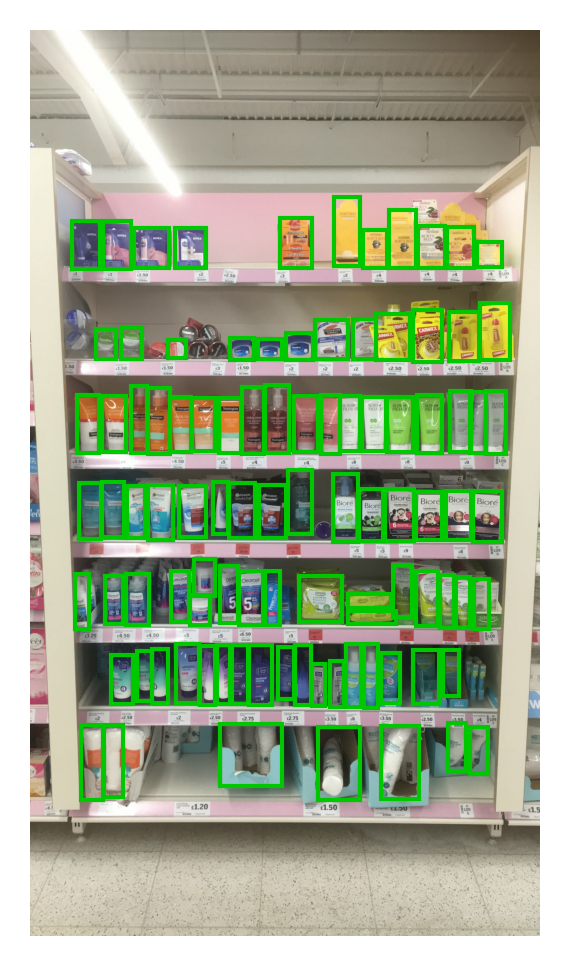

In [42]:
matplotlib.rcParams["figure.dpi"] = 300

sample_id = np.random.randint(0, len(img_objs), 1)[0]

img_obj = img_objs[sample_id]
pred_obj = predict_objs[sample_id]

img = np.asarray(Image.open(io.BytesIO(img_obj.get()["Body"].read())))
preds = json.loads(pred_obj.get()["Body"].read().decode("utf-8"))

sample_fig = plot_predictions_on_image(img, preds, 0.40, True)